In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import numpy
import xml.etree.ElementTree as ET
from glob import glob
import datetime
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Liulin

In [2]:
filename = './data/HIMAC/liulin/1801202205.y14'

# extract time
path = filename.split('/')
time = path[-1].split('.')
print time
date_object = datetime.datetime.strptime(time[0], '%y%m%d%H%M')
print date_object

# read data
liulin = pd.read_csv(filename, header = None, sep = ' ', skiprows = 1) # read Liulin data Y
liulin = liulin.drop(256, axis=1) # delete last empty column
infile = open(filename, 'r')
header = infile.readline()
print header # print data header
exposition = header.split(' ')[4].split('[')[0] # extract exposition time  
exposition_val = float(exposition)
exposition += 'S'
print exposition

# compute time series
#dates = pd.date_range(date_object, freq='5T', periods=len(liulin)).tolist()


['1801202205', 'y14']
2018-01-20 22:05:00
MDU-14  EXPOSITION = 60[sec]

60S


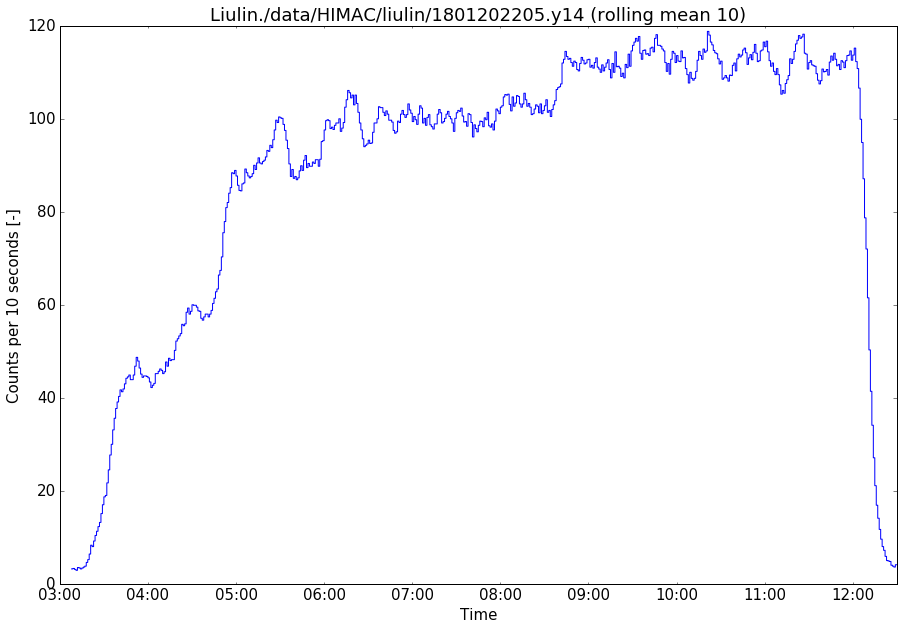

In [37]:
#liulin_data = pd.DataFrame(index = pd.date_range(date_object, freq='5T', periods=len(liulin)).tolist(), data = liulin.as_matrix())
# index liulin data (compute time)
liulin_data = pd.DataFrame(index = pd.date_range(date_object, freq=exposition, periods=len(liulin)).tolist(), data = liulin.as_matrix())
liulin_data['flux'] = liulin_data[range(0,256)].sum(axis=1)
#liulin_data = liulin_data.loc['2018-08-02 17:00:00':'2018-08-03 13:00:00']
#ABSjets liulin_data = liulin_data.loc['2017-11-29 12:00:00':'2017-11-29 15:30:00']
liulin_data = liulin_data.loc['2018-01-21 03:00:00':'2018-01-21 12:30:00']

WINDOW = 10
liulin_data['flux'] = pd.rolling_mean(liulin_data['flux'],WINDOW)
liulin_data['flux'] = liulin_data['flux'] 

#liulin_data
plt.figure(figsize=(15, 10))
matplotlib.rcParams.update({'font.size': 15})
liulin_data['flux'].plot(drawstyle='steps')
plt.title('Liulin' + filename + ' (rolling mean ' + str(WINDOW) + ')')
plt.ylabel('Counts per 10 seconds [-]')
plt.xlabel('Time')
#plt.ylim(0, 20)


## AIRDOS

In [6]:
fto = './data/HIMAC/AIRDOS_T4/DATALOG.TXT' #  File to Open
l=[]
l.extend(range(0,520))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python')

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)

# Convert strings to numbers
#df = df.apply(pd.to_numeric, errors='ignore')

#df.iloc[:,0:13]

#df

In [7]:
date = np.nan #pd.to_datetime('210317000000.00', format='%d%m%y%H%M%S.%f')
altitude = np.nan
LatDD = np.nan
LonDD = np.nan
speed = np.nan
flag=0

for i,r in df.iterrows():
    if (r[0] == '$GPRMC'):
        date = pd.to_datetime(str(r[9])+str(r[1]), format='%d%m%y%H%M%S.%f',errors='coerce')
        flag = 1
        speed = r[7]
        
    if (r[0] == '$GPGGA'):
        altitude = r[9]

    df.set_value(i,'date',date)
    #df.set_value(i,'altitude',np.nan)
    df.set_value(i,'altitude',altitude)
    df.set_value(i,'speed',speed)

    if (r[0] == '$CANDY'):
        date = date + pd.Timedelta(seconds=14)
        df.set_value(i,'date',date)
        #if (flag==1):
        #    df.set_value(i,'altitude',altitude)
        #    flag=0
        
dfo = df
#dfo.reset_index(inplace=True)
dfo.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)

dfo.to_csv('radiation.csv')

## Liulin & AIRDOS

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



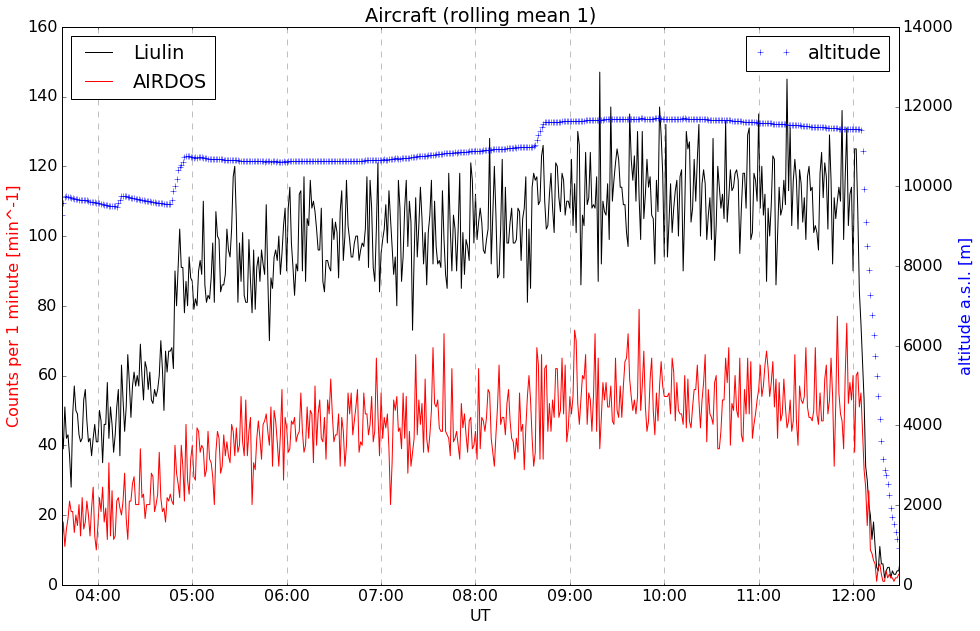

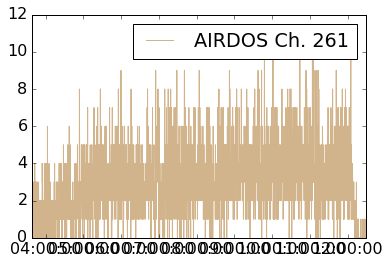

In [276]:
#DeviceName = 'AIRDOS A005'
DeviceName = 'AIRDOS T4'

dfo = pd.read_table('radiation.csv', sep=',', header=0)
#dfo = dfo.dropna(how='any')
dfo = dfo.dropna(subset=['date'])
dfo['date'] = pd.to_datetime(dfo['date'])
dfo = dfo.set_index(['date'])
#xx = dfo.loc['2018-01-03 17:00:00':]
#xx = dfo.loc['2018-06-23 11:00:00':'2018-06-27 10:00:00']
#ABSjets xx = dfo.loc['2017-11-29 12:30:00':'2017-11-29 16:00:00']
xx = dfo.loc['2018-01-21 02:00:00':'2018-01-21 12:30:00']
#xx = dfo

xxl = liulin_data

NOISE_LEVEL=261
LAST_CHANNEL=515
xx['flux'] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)
liulin_data['flux'] = liulin_data[range(0,256)].sum(axis=1)

xxs = xx.resample('1 min', how='sum')
xxm = xx.resample('1 min', how='mean')

#pandas.rolling_mean(arg, window, min_periods=None, freq=None, center=False, how=None, **kwargs)
WINDOW = 1
xxs['flux'] = pd.rolling_mean(xxs['flux'],WINDOW)
xxl['flux'] = pd.rolling_mean(liulin_data['flux'],WINDOW)

plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 16})

xxl['flux'].plot(c='black', label = 'Liulin') # drawstyle='steps', 
xxs['flux'].plot(c='red', label = 'AIRDOS')
#plt.plot(xx.iloc[:,NOISE_LEVEL],c='tan',label='AIRDOS 1. Ch.',zorder=1)

plt.ylim([0,160])

plt.xlabel('UT')
plt.ylabel('Counts per 1 minute [min^-1]', color='red')
plt.legend(loc=2)

plt.grid(b=True, which='major', color='grey', linestyle='')
plt.grid(b=True, which='minor', color='grey', linestyle='--')

ax = plt.twinx()

plt.ylim([0,14000])
xxm['altitude'].plot(c='b', marker='+', linewidth='2', linestyle='none', label='altitude')
#xx['altitude'].plot(c='b', label='alt', linewidth='1')
plt.ylabel('altitude a.s.l. [m]', color='b')

plt.grid(b=True, which='major', color='grey', linestyle='')
plt.grid(b=True, which='minor', color='grey', linestyle='')
plt.legend()
plt.title('Aircraft (rolling mean ' + str(WINDOW) + ')')

plt.savefig("aircraft.svg", format="svg")

#
'''flux to file
xxx = pd.DataFrame()
xxx = xx[['altitude','flux','speed']]
xxx.to_csv('flux.csv')
#'''

plt.figure()
#matplotlib.rcParams.update({'font.size': 10})
plt.plot(xx.iloc[:,NOISE_LEVEL],c='tan',label='AIRDOS Ch. '+str(NOISE_LEVEL),zorder=1)
plt.legend()


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



"flux to file\nxxx = pd.DataFrame()\nxxx = xx[['altitude','flux','speed']]\nxxx.to_csv('flux.csv')\n#"

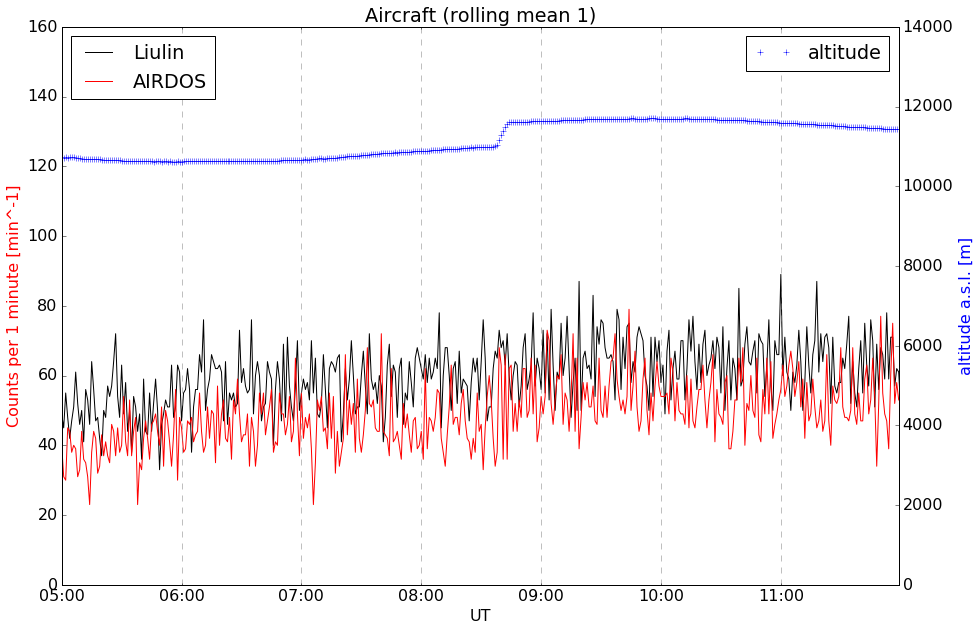

In [273]:
#DeviceName = 'AIRDOS A005'
DeviceName = 'AIRDOS T4'
plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 16})

dfo = pd.read_table('radiation.csv', sep=',', header=0)
#dfo = dfo.dropna(how='any')
dfo = dfo.dropna(subset=['date'])
dfo['date'] = pd.to_datetime(dfo['date'])
dfo = dfo.set_index(['date'])
#xx = dfo.loc['2018-01-03 17:00:00':]
#xx = dfo.loc['2018-06-23 11:00:00':'2018-06-27 10:00:00']
#ABSjets xx = dfo.loc['2017-11-29 12:30:00':'2017-11-29 16:00:00']
xx = dfo.loc['2018-01-21 02:00:00':'2018-01-21 12:30:00']
xx = dfo.loc['2018-01-21 05:00:00':'2018-01-21 12:00:00']
#xx = dfo

xxl = liulin_data

NOISE_LEVEL=261
LAST_CHANNEL=515
xx['flux'] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)
liulin_data['flux'] = liulin_data[range(3,256)].sum(axis=1)

xxs = xx.resample('1 min', how='sum')
xxm = xx.resample('1 min', how='mean')

#pandas.rolling_mean(arg, window, min_periods=None, freq=None, center=False, how=None, **kwargs)
WINDOW = 1
xxs['flux'] = pd.rolling_mean(xxs['flux'],WINDOW)
xxl['flux'] = pd.rolling_mean(liulin_data['flux'],WINDOW)

plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 16})

xxl['flux'].plot(c='black', label = 'Liulin') # drawstyle='steps', 
xxs['flux'].plot(c='red', label = 'AIRDOS')
#plt.plot(xx.iloc[:,NOISE_LEVEL],c='tan',label='AIRDOS 1. Ch.',zorder=1)

plt.ylim([0,160])

plt.xlabel('UT')
plt.ylabel('Counts per 1 minute [min^-1]', color='red')
plt.legend(loc=2)

plt.grid(b=True, which='major', color='grey', linestyle='')
plt.grid(b=True, which='minor', color='grey', linestyle='--')

ax = plt.twinx()

plt.ylim([0,14000])
xxm['altitude'].plot(c='b', marker='+', linewidth='2', linestyle='none', label='altitude')
#xx['altitude'].plot(c='b', label='alt', linewidth='1')
plt.ylabel('altitude a.s.l. [m]', color='b')

plt.grid(b=True, which='major', color='grey', linestyle='')
plt.grid(b=True, which='minor', color='grey', linestyle='')
plt.legend()
plt.title('Aircraft (rolling mean ' + str(WINDOW) + ')')

plt.savefig("aircraft2.svg", format="svg")

#
'''flux to file
xxx = pd.DataFrame()
xxx = xx[['altitude','flux','speed']]
xxx.to_csv('flux.csv')
#'''


In [311]:
import plotly.plotly as py
import plotly.graph_objs as go

LOW_ENERGY = 0

e1 = ['2018-01-21 02:00:00','2018-01-21 12:30:00']

ener1 = liulin_data.ix[e1[0]:e1[1],LOW_ENERGY:256].sum()

print ener1[2:].sum()

# Solving following system of linear equations
# 237a + b = 6.12
# 215a + b = 5.49
tl = 0.5
#l = np.array([[41, 1],[62,1]])
#r = np.array([1.02, 1.41])
l = np.array([[275, 1],[364,1]])
r = np.array([1, 5.4])

coef = np.linalg.solve(l,r)
print coef[0], coef[1]

e = pd.DataFrame()
e['1'] = ener1
e['index'] = ener1.index
#e['x'] = (e['index']) * coef[0] + coef[1]
e['x'] =  linspace(0.0407, 20.7977, 256)

data = [
    go.Scatter(
        x=e['x'],
        y=e['1'],
        name='aircraft',
        yaxis='y',
        line=dict(
        shape='hvh'
        )
    ),    
    ]
        
layout = go.Layout(
    title='Liulin',
    yaxis=dict(
        title='counts',
        type='log',
        #range = [0,20000]
    ),
    xaxis=dict(
        title='ε [MeV]',
    ),
)

e.to_csv('./data/liulin.csv')

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='ble')


47046
0.0494382022472 -12.595505618


In [312]:
import plotly.plotly as py
import plotly.graph_objs as go

ee = pd.read_table('./data/liulin.csv', sep=',', header=0,engine='python' )

# Solving following system of linear equations
# 237a + b = 6.12
# 215a + b = 5.49
tl = 0.5
#l = np.array([[41, 1],[62,1]])
#r = np.array([1.02, 1.41])
#AIRDOS T4
l = np.array([[275, 1],[364,1]])
r = np.array([1, 5.4])
#A2
#l = np.array([[393, 1],[505,1]])
#r = np.array([2.45, 4.39])

coef = np.linalg.solve(l,r)
print coef[0], coef[1]


e1 = ['2018-01-21 05:00:00','2018-01-21 12:00:00']

ener1 = dfo.ix[e1[0]:e1[1],259:515].sum()

e = pd.DataFrame()
e['1'] = ener1
e['index'] = pd.to_numeric(ener1.index)
e['x'] = (e['index']) * coef[0] + coef[1]

data = [
    go.Scatter(
        x=e['x'],
        y=e['1'],
        name='AIRDOS<br>49.4 keV/Ch.',
        #yaxis='y',
        line=dict(
        shape='hvh'
        )
    ),    
    go.Scatter(
        x=ee['x'],
        y=ee['1'],
        name='Liulin<br>81.4 keV/Ch.',
        #yaxis='y',
        line=dict(
        shape='hvh'
        )
    ),    
    ]
        
layout = go.Layout(
    title='Aircraft',
    font=dict(family='Courier New, monospace', size=18, color='#7f7f7f'),
    yaxis=dict(
        title='counts',
        type='log',
        #range = [0,100]
    ),
    xaxis=dict(
        title='ε [MeV]',
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='ble')

0.0494382022472 -12.595505618


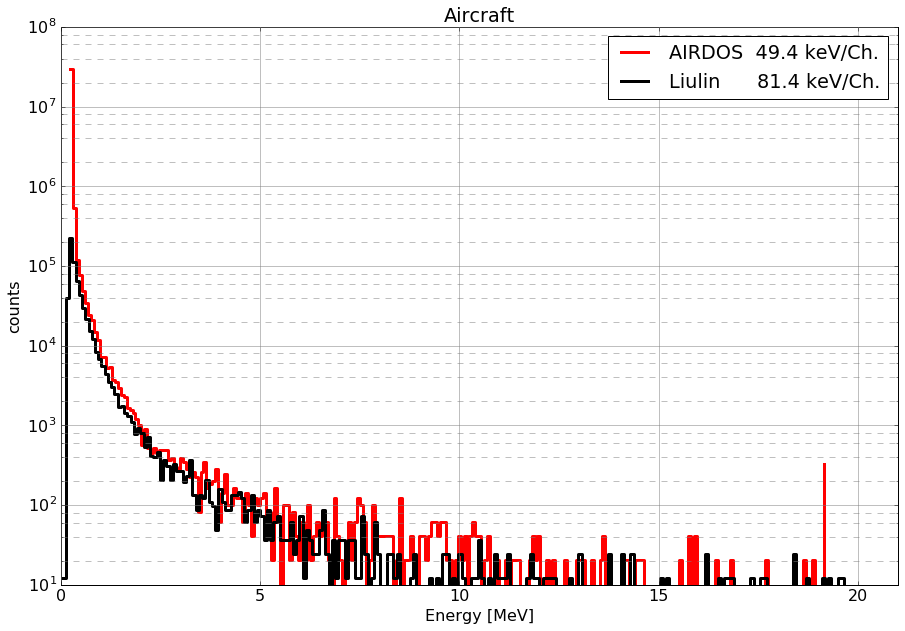

In [333]:
plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 16})

plt.plot(1.5*e['x'],e['1']/0.0494, c='r', lw=3, drawstyle='steps-post', label='AIRDOS  49.4 keV/Ch.')
plt.plot(ee['x'],ee['1']/0.0814, c='black', lw=3, drawstyle='steps-post', label='Liulin      81.4 keV/Ch.')
#plt.ylim(1, 10e4)
plt.xlim(0, 21)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('counts')
plt.legend()
plt.title('Aircraft')
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='--')

plt.savefig("aircraft_spectra.svg", format="svg")
e.to_csv('./data/liulin_spectrum.csv')
ee.to_csv('./data/airdos_spectrum.csv')


In [325]:
from_energy = 0.3
to_energy = 12.7
#e.loc[e['x']>=from_energy]
#ee.loc[ee['x']>=from_energy]
e['dose']=e['1']*e['x']
ee['dose']=ee['1']*ee['x']

liulin_particles = ee.loc[(ee['x']>=from_energy)]['1'].sum()
airdos_particles = e.loc[(e['x']>=from_energy)]['1'].sum()

liulin_dose = ee.loc[(ee['x']>=from_energy)&(ee['x']<=to_energy)]['dose'].sum()
airdos_dose = e.loc[(e['x']>=from_energy)&(e['x']<=to_energy)]['dose'].sum()

print 'Liulin','AIRDOS'
print liulin_particles, airdos_particles
print liulin_dose, airdos_dose


Liulin AIRDOS
19605 14595.0
14724.2832 8828.64494382


In [337]:
ee

,Unnamed: 0,1,index,x,dose
0,0,1,0,0.0407,0.0407
1,1,3217,1,0.1221,392.7957
2,2,18398,2,0.2035,3743.9930
3,3,9043,3,0.2849,2576.3507
4,4,5283,4,0.3663,1935.1629
5,5,3530,5,0.4477,1580.3810
6,6,2418,6,0.5291,1279.3638
7,7,1767,7,0.6105,1078.7535
8,8,1243,8,0.6919,860.0317
9,9,991,9,0.7733,766.3403
